# Analyze UKB phenotypes using in-sample LD file

In [1]:
using CSV
using DataFrames
using DelimitedFiles

# helper function to submit 1 job to run 1 command
function submit(command::String, ncores::Int, total_mem::Number, 
        joblog_dir::String="/oak/stanford/groups/zihuai/solveblock/joblogs"; 
        jobname="submit", waitfor=Int[], verbose=true, highp=false)
    mem = round(Int, total_mem / ncores) # memory per core
    filename = "$jobname.sh"
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#")
        println(io, "#SBATCH --job-name=$jobname")
        println(io, "#")
        if highp
            println(io, "#SBATCH --time=168:00:00")
        else
            println(io, "#SBATCH --time=24:00:00")
        end
        println(io, "#SBATCH --cpus-per-task=$ncores")
        println(io, "#SBATCH --mem-per-cpu=$(mem)G")
        if highp
            println(io, "#SBATCH --partition=candes,zihuai")
        else
            println(io, "#SBATCH --partition=candes,zihuai,normal,owners")
        end
        println(io, "#SBATCH --output=$(joinpath(joblog_dir, "slurm-%j.out"))")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, "module load julia/1.9.4")
        println(io, "module load R/4.0.2")
#         println(io, "module load biology plink/1.90b5.3")
#         println(io, "export OPENBLAS_NUM_THREADS=1")
#         println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
        println(io, "")
        println(io, "# run code")
        println(io, "echo \"$command\"")
        println(io, "$command")
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job and capture job ID
    io = IOBuffer()
    if length(waitfor) != 0
        run(pipeline(`sbatch --dependency=afterok:$(join(waitfor, ':')) $filename`; stdout=io))
    else
        run(pipeline(`sbatch $filename`; stdout=io))
    end
    msg = String(take!(io))
    verbose && print(stdout, msg)
    jobid = parse(Int, strip(msg)[21:end])
    # clean up and return job ID
    close(io)
    rm(filename, force=true)
    return jobid
end

# helper function to submit 1 job to run multiple commands
function submit(commands::Vector{String}, ncores::Int, total_mem::Number, 
        joblog_dir::String="/oak/stanford/groups/zihuai/solveblock/joblogs"; 
        jobname="submit", waitfor=Int[], verbose=true, highp=false)
    mem = round(Int, total_mem / ncores) # memory per core
    filename = "$jobname.sh"
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#")
        println(io, "#SBATCH --job-name=$jobname")
        println(io, "#")
        if highp
            println(io, "#SBATCH --time=168:00:00")
        else
            println(io, "#SBATCH --time=24:00:00")
        end
        println(io, "#SBATCH --cpus-per-task=$ncores")
        println(io, "#SBATCH --mem-per-cpu=$(mem)G")
        if highp
            println(io, "#SBATCH --partition=candes,zihuai")
        else
            println(io, "#SBATCH --partition=candes,zihuai,normal,owners")
        end
        println(io, "#SBATCH --output=$(joinpath(joblog_dir, "slurm-%j.out"))")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, "module load julia/1.9.4")
        println(io, "module load R/4.0.2")
#         println(io, "module load biology plink/1.90b5.3")
#         println(io, "export OPENBLAS_NUM_THREADS=1")
#         println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
        println(io, "")
        for command in commands
            println(io, "echo \"$command\"")
            println(io, "$command")
        end
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job and capture job ID
    io = IOBuffer()
    if length(waitfor) != 0
        run(pipeline(`sbatch --dependency=afterok:$(join(waitfor, ':')) $filename`; stdout=io))
    else
        run(pipeline(`sbatch $filename`; stdout=io))
    end
    msg = String(take!(io))
    verbose && print(stdout, msg)
    jobid = parse(Int, strip(msg)[21:end])
    # clean up and return job ID
    close(io)
    rm(filename, force=true)
    return jobid
end


"Run a Cmd object, returning the stdout & stderr contents plus the exit code"
function execute(cmd::Cmd)
    out = Pipe()
    err = Pipe()

    process = run(pipeline(ignorestatus(cmd), stdout=out, stderr=err))
    close(out.in)
    close(err.in)

    return (
        stdout = String(read(out)), 
        stderr = String(read(err)),  
        code = process.exitcode
    )
end

function get_job_names()
    data_str, _, _ = execute(`squeue -u bbchu -h -o "%.30j"`)
    lines = split(data_str, "\n")
    jobnames = String[]
    for line in lines
        push!(jobnames, strip(line))
    end
    return jobnames
end

get_job_names (generic function with 1 method)

## Run analysis

This notebook: 
+ Reads phenotypes from "/oak/stanford/groups/zihuai/solveblock/phenotypes.QC.britishonly.csv"
+ Regresses out the effect of covariates:
    - sex
    - age
    - age^2
    - sex*age
    - sex*age^2
    - top 10 PC
+ Computes the score statistic $Z = \frac{1}{\sqrt{N}}X'y$
+ Plugs the resulting Z scores into ghostknockoff pipeline

In [ ]:
# put in file /oak/stanford/groups/zihuai/solveblock/run_ukb.jl

phenotype = ARGS[1]
seed = ARGS[2]

# packages
using SnpArrays, CSV, DataFrames, StatsBase
ghostknockoffgwas = "/home/groups/sabatti/.julia/dev/GhostKnockoffGWAS/app_linux_x86/bin/GhostKnockoffGWAS"
manhattan_exe = "/home/groups/sabatti/.julia/dev/GhostKnockoffGWAS/src/manhattan.R"

# files
phenofile = "/oak/stanford/groups/zihuai/solveblock/phenotypes.QC.britishonly.csv"
genofile = "/oak/stanford/groups/zihuai/solveblock/array/ukb_gen_british"
covfile = "/oak/stanford/groups/zihuai/solveblock/covariates.csv"
outdir = "/oak/stanford/groups/zihuai/solveblock/result_seed$seed"
zfile = "$outdir/$phenotype.zfile.txt"
# LD_files = "/oak/stanford/groups/zihuai/solveblock/LD_files" # FDR inflation in simulations
# LD_files = "/oak/stanford/groups/zihuai/solveblock/LD_files_ld_split/min_error" # controls FDR but block sizes too large -> LD files ~80G
LD_files = "/oak/stanford/groups/zihuai/solveblock/LD_files_ld_split/default" # controls FDR and LD file ~20G
outfile = "$outdir/$phenotype"
plot_output_path = outdir
knockoff_outfile_path = outfile * ".txt"

# read covariates
cov = CSV.read(covfile, DataFrame)
C = Matrix(cov[!, 2:end])

# read phenotypes, regress out effect of covariates, and standardize to mean 0 var 1
df = CSV.read(phenofile, DataFrame)
y_raw = df[!, phenotype]
y = y_raw - C*inv(C'*C)*(C'*y_raw)
StatsBase.zscore!(y, mean(y), std(y))

# genotype data
xdata = SnpData(genofile)
X = SnpLinAlg{Float64}(xdata.snparray, center=true, scale=true)
n, p = size(X)

# compute Z-scores
z = X' * y ./ sqrt(n)

# run GhostKnockoffGWAS
CSV.write(zfile, 
    DataFrame("CHR"=>xdata.snp_info.chromosome,"POS"=>xdata.snp_info.position,
              "REF"=>xdata.snp_info.allele1,"ALT"=>xdata.snp_info.allele2,"Z"=>z))
run(`$ghostknockoffgwas --zfile $zfile --LD-files $LD_files --N $n --genome-build 19 --out $outfile --skip-shrinkage-check true --seed $seed`)

# make manhattan plot
run(`Rscript --vanilla $manhattan_exe $knockoff_outfile_path $plot_output_path $phenotype 0.1`)

Submit jobs

In [9]:
exe = "/oak/stanford/groups/zihuai/solveblock/run_ukb.jl"
phenotypes = ["height", "weight", "waist_circ", "bmi", "dbp", "sbp", "whitecell", "redcell", 
    "haemoglobin", "haematocrit", "corpuscular_volume", "corpuscular_haemoglobin", "redcell_width", 
    "platelet", "platelet_volume", "platelet_width", "lymphocyte", "monocyte", "neutrophill", 
    "eosinophill", "basophill", "nucleated_redcell", "reticulocyte", "reticulocyte_volume", 
    "spheredcell_volume", "body_fat_mass"] # 26 continuous traits
seed = 5
for phenotype in phenotypes
    outfile = "/oak/stanford/groups/zihuai/solveblock/result_seed$(seed)/$phenotype.txt"
    if !isfile(outfile)
        submit("julia $exe $phenotype $seed", 1, 64, jobname=phenotype)
    end
end

Submitted batch job 58288364
Submitted batch job 58288367
Submitted batch job 58288371
Submitted batch job 58288373
Submitted batch job 58288377
Submitted batch job 58288378
Submitted batch job 58288385
Submitted batch job 58288390
Submitted batch job 58288393
Submitted batch job 58288397
Submitted batch job 58288402
Submitted batch job 58288409
Submitted batch job 58288412
Submitted batch job 58288417
Submitted batch job 58288422
Submitted batch job 58288427
Submitted batch job 58288429
Submitted batch job 58288434
Submitted batch job 58288437
Submitted batch job 58288439
Submitted batch job 58288500
Submitted batch job 58288503
Submitted batch job 58288509
Submitted batch job 58288514
Submitted batch job 58288519
Submitted batch job 58288524


## Count number of indep discoveries

In [6]:
using CSV
using DataFrames
using ProgressMeter
using Plots
using Statistics

function count_discoveries(
    outfile::String; # needs :rsid, :chr, :pos_hg$(hg_build), :pvals, :W, :group, 
    loc_w::Int=1000000, # width of independent loci
    hg_build::Int=19
    )
    result = CSV.read(outfile, DataFrame)
    pheno_name = splitext(basename(outfile))[1]
    summary = CSV.read(joinpath(dirname(outfile), pheno_name * "_summary.txt"), DataFrame, header=false)

    ########################################
    # marginal analysis 
    ########################################
    idx = findall(x -> !ismissing(x) && !isnan(x) && !isinf(x) && x < 5e-8, result[:, :pvals])
    result_marginal = find_independent_snps!(result[idx, :], loc_w=loc_w)

    ########################################
    # knockoff analysis
    ########################################

    # optional: plot only W ≥ 0
    result = result[findall(x -> x > 0, result[!, :W]), :]
 
    nknockoff_discovered = Int[]
    for target_fdr in [0.1, 0.2]
        # SNPs that are selected
        result_knockoff = result[findall(x -> x ≤ target_fdr, result[!, :qvals]), :]

        # for each group, only keep SNP with largest Z score
        keep_idx = Int[]
        for g in unique(result_knockoff[!, "group"])
            idx = findall(x -> x == g, result_knockoff[!, "group"])
            zscores = result_knockoff[idx, "zscores"]
            z, z_idx = findmax(abs.(zscores))
            push!(keep_idx, idx[z_idx])
        end
        result_knockoff = result_knockoff[keep_idx, :]
        num_sig_groups = size(result_knockoff, 1)

        # find independent SNPs
        result_knockoff = find_independent_snps!(result_knockoff, loc_w=loc_w)
        ko_num_significant = length(unique(result_knockoff[!, "IND"]))
        push!(nknockoff_discovered, ko_num_significant)
    end
    
    marginal_num_significant = length(unique(result_marginal[!, "IND"]))
    nregions = summary[6, 2]
    nsnps = summary[7, 2]
    mean_LD_shrinkage = summary[9, 2]
    
    return marginal_num_significant, nknockoff_discovered[1], nknockoff_discovered[2], 
        nregions, nsnps, mean_LD_shrinkage
end

# if marginal analysis, result_subsetted = result subsetted to SNPs with p-value < 5e-8
# if knockoff analysis, result_subsetted = result subsetted to selected groups where each group has 1 representatives
# output = subsetted dataframe containing 
# 2 additional columns "IND" classifying which SNPs are independent and "TOP" 
# finding the most significant SNPs in an independent region
function find_independent_snps!(result_subsetted::DataFrame; loc_w::Int=1000000, hg_build::Int=19)
    result_subsetted[!, :IND] = zeros(Int, size(result_subsetted, 1))
    result_subsetted[!, :TOP] = falses(size(result_subsetted, 1))
    
    # find independent loci
    pos = result_subsetted[!, "pos_hg$(hg_build)"]
    inds = 0
    for chr in unique(result_subsetted[!, :chr])
        BPs = result_subsetted[findall(x -> x == chr, result_subsetted[:, :chr]), "pos_hg$(hg_build)"]
        BP_first = BPs[1]
        BP_prv = 0
        for bp in BPs
            if bp == BP_first
                inds = inds + 1
            else
                bp_sw = bp - BP_prv
                if bp_sw > loc_w
                    inds += 1
                end
            end
            idx = findfirst(row -> row[:chr] == chr && row["pos_hg$(hg_build)"] == bp, eachrow(result_subsetted))
            result_subsetted[idx, "IND"] = inds
            BP_prv = bp
        end
    end
  
    # find top SNPs in independent loci
    for i in unique(result_subsetted[!, "IND"])
        idx = findall(x -> x == i, result_subsetted[!, "IND"])
        pvals = result_subsetted[idx, "pvals"]
        result_subsetted[idx[argmin(pvals)], "TOP"] = true
    end
    
    return result_subsetted
end

function make_plot(seed)
    outdir = "/oak/stanford/groups/zihuai/solveblock/result_seed$seed"
    phenotypes = ["height", "weight", "waist_circ", "bmi", "dbp", "sbp", "whitecell", "redcell", 
        "haemoglobin", "haematocrit", "corpuscular_volume", "corpuscular_haemoglobin", "redcell_width", 
        "platelet", "platelet_volume", "platelet_width", "lymphocyte", "monocyte", "neutrophill", 
        "eosinophill", "basophill", "nucleated_redcell", "reticulocyte", "reticulocyte_volume", 
        "spheredcell_volume", "body_fat_mass"] # 26 phenotypes

    # aggregate result
    studies = DataFrame("phenotype"=>String[], "marginal"=>Int[], 
        "GK_fdr10"=>Int[], "GK_fdr20"=>Int[], "LD_shrinkage"=>Float64[])
    @showprogress for phenotype in phenotypes
        try
            outfile = joinpath(outdir, "$phenotype.txt")
            marginal_num_significant, ko_num_fdr10, ko_num_fdr20, nregions, nsnps, mean_LD_shrinkage = 
                count_discoveries(outfile)
            push!(studies, [phenotype, marginal_num_significant, ko_num_fdr10, ko_num_fdr20, mean_LD_shrinkage])
        catch
            println("phenotype $phenotype failed!")
        end
    end

    # make plot
    marginal = studies[!, "marginal"]
    knockoff10 = studies[!, "GK_fdr10"]
    knockoff20 = studies[!, "GK_fdr20"]
    difference = mean(knockoff10 - marginal), mean(knockoff20 - marginal)
    @show difference
    plt = scatter(marginal, knockoff10, xlabel="Number of indep marginal discoveries", 
        ylabel="Number of indep knockoff discoveries", label="Target FDR = 0.1", fmt=:png,
        ylim=(0, 600), xlim=(0, 600), legend=:bottomright)
    scatter!(plt, marginal, knockoff20, label="Target FDR = 0.2")
    Plots.abline!(plt, 1, 0, line=:dash, label=false)

    return studies, plt
end

make_plot (generic function with 1 method)

phenotype height failed!
phenotype weight failed!


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


phenotype waist_circ failed!
phenotype bmi failed!
phenotype dbp failed!
phenotype sbp failed!
phenotype whitecell failed!
phenotype redcell failed!
phenotype haemoglobin failed!
phenotype haematocrit failed!
phenotype corpuscular_volume failed!
phenotype corpuscular_haemoglobin failed!
phenotype redcell_width failed!
phenotype platelet failed!
phenotype platelet_volume failed!
phenotype platelet_width failed!
phenotype lymphocyte failed!
phenotype monocyte failed!
phenotype neutrophill failed!
phenotype eosinophill failed!
phenotype basophill failed!
phenotype nucleated_redcell failed!
phenotype reticulocyte failed!
phenotype reticulocyte_volume failed!
phenotype spheredcell_volume failed!
phenotype body_fat_mass failed!
difference = (NaN, NaN)


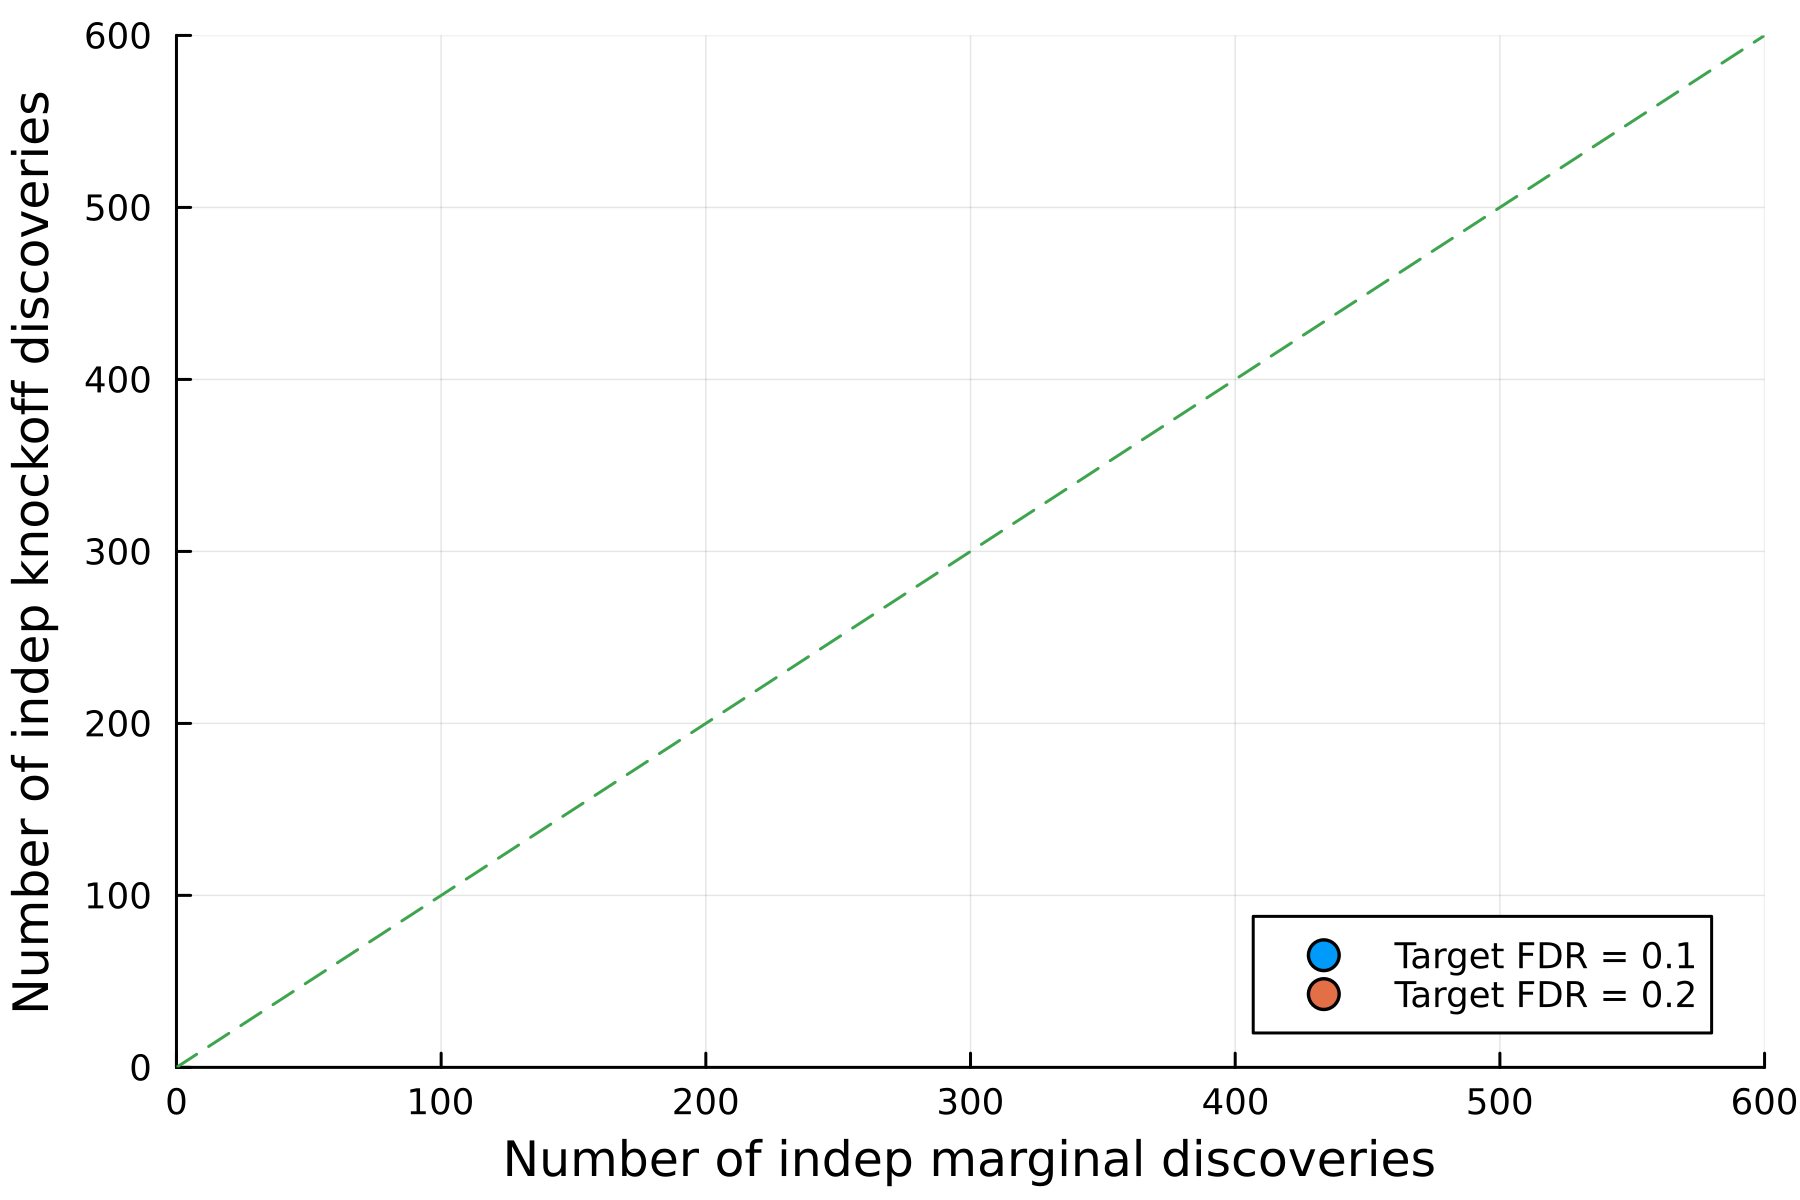

In [5]:
seed = 5
studies, plt = make_plot(seed)
plot(plt, dpi=300)

# Old results (using `obj=min_error`)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:37


difference = (14.807692307692308, 136.53846153846155)


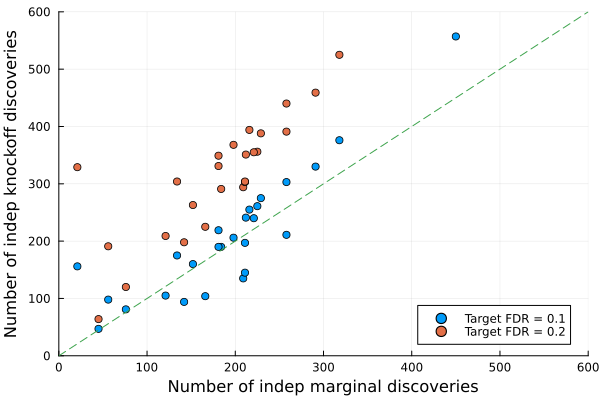

In [22]:
seed = 2023
studies, plt = make_plot(seed)
plt

Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


difference = (19.0, 149.15384615384616)


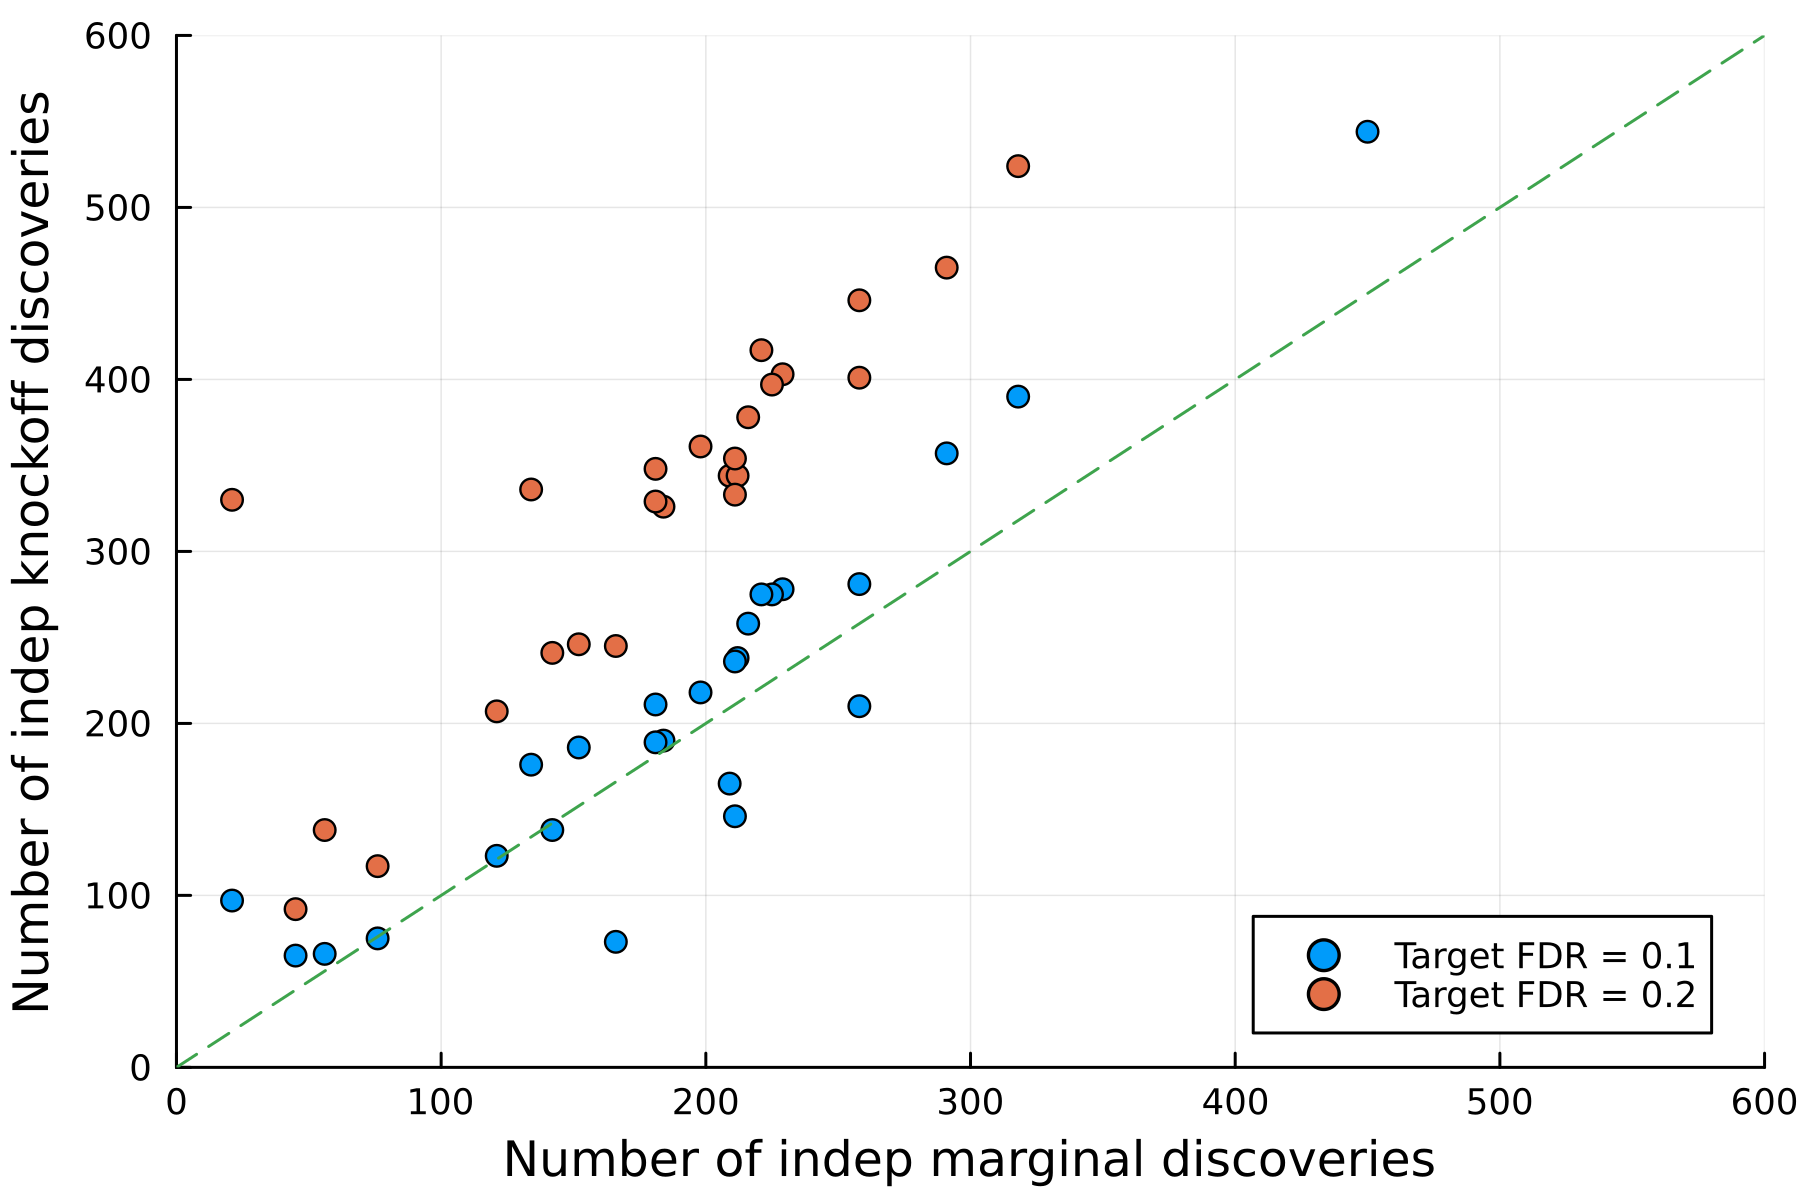

In [36]:
seed = 5
studies, plt = make_plot(seed)
plot(plt, dpi=300)

In [37]:
studies

Row,phenotype,marginal,GK_fdr10,GK_fdr20,LD_shrinkage
,String,Int64,Int64,Int64,Float64
1,height,450,544,722,0.00299022
2,weight,258,210,401,0.00137417
3,waist_circ,166,73,245,0.0019305
4,bmi,209,165,344,0.00143746
5,dbp,121,123,207,0.00182111
6,sbp,142,138,241,0.00155024
7,whitecell,184,190,326,0.00193891
8,redcell,258,281,446,0.00238108
9,haemoglobin,198,218,361,0.00175119


### studies

## Old result (with 1703 EUR regions)

difference = (38.73076923076923, 188.23076923076923)


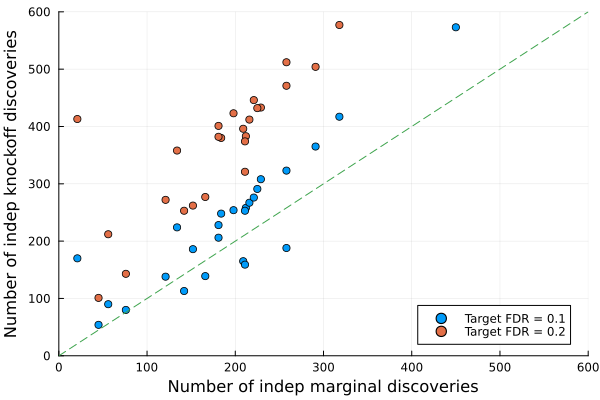

In [78]:
outdir = "/oak/stanford/groups/zihuai/solveblock/result"
phenotypes = ["height", "weight", "waist_circ", "bmi", "dbp", "sbp", "whitecell", "redcell", 
    "haemoglobin", "haematocrit", "corpuscular_volume", "corpuscular_haemoglobin", "redcell_width", 
    "platelet", "platelet_volume", "platelet_width", "lymphocyte", "monocyte", "neutrophill", 
    "eosinophill", "basophill", "nucleated_redcell", "reticulocyte", "reticulocyte_volume", 
    "spheredcell_volume", "body_fat_mass"] # 26 phenotypes

# aggregate result
studies = DataFrame("phenotype"=>String[], "marginal"=>Int[], 
    "GK_fdr10"=>Int[], "GK_fdr20"=>Int[], "LD_shrinkage"=>Float64[])
for phenotype in phenotypes
    try
        outfile = joinpath(outdir, "$phenotype.txt")
        marginal_num_significant, ko_num_fdr10, ko_num_fdr20, nregions, nsnps, mean_LD_shrinkage = 
            count_discoveries(outfile)
        push!(studies, [phenotype, marginal_num_significant, ko_num_fdr10, ko_num_fdr20, mean_LD_shrinkage])
    catch
        println("phenotype $phenotype failed!")
    end
end


# make plot
marginal = studies[!, "marginal"]
knockoff10 = studies[!, "GK_fdr10"]
knockoff20 = studies[!, "GK_fdr20"]
difference = mean(knockoff10 - marginal), mean(knockoff20 - marginal)
@show difference
plt = scatter(marginal, knockoff10, xlabel="Number of indep marginal discoveries", 
    ylabel="Number of indep knockoff discoveries", label="Target FDR = 0.1", fmt=:png,
    ylim=(0, 600), xlim=(0, 600), legend=:bottomright)
scatter!(plt, marginal, knockoff20, label="Target FDR = 0.2")
Plots.abline!(plt, 1, 0, line=:dash, label=false)

In [79]:
studies

Row,phenotype,marginal,GK_fdr10,GK_fdr20,LD_shrinkage
,String,Int64,Int64,Int64,Float64
1,height,450,573,722,0.0018339
2,weight,258,188,471,0.00141803
3,waist_circ,166,139,277,0.00144682
4,bmi,209,165,396,0.0014171
5,dbp,121,138,272,0.00138143
6,sbp,142,113,253,0.00147337
7,whitecell,184,248,380,0.00163781
8,redcell,258,323,512,0.000936219
9,haemoglobin,198,254,423,0.000889804
